<a href="https://colab.research.google.com/github/tuliofalmeida/Practicals-ratgroup/blob/main/Tutorials%20python/Tutorial1_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading, handling and subsetting the data

The set of data we will work on in this tutorial series consists in recordings performed in the hippocampus while rats run back and forth on a linear track to get a water reward. Additionally, the animal received an aversive air puff when crossing a certain position along the track and only in one running direction.
The recording sessions were organized in 5 consecutive conditions: 1) in the "**pre-run**" condition, the animal was free to evolve on the linear track without receiving air puffs; 2) in the "**pre-sleep**" condition, the animal was brought to its home cage for sleep; 3) in the "**run**" condition, the animal was placed back on the track. Ths is the condition where it receives air puffs when crossing a particular position in a specific direction; 4) in the "**post-sleep**" condition, the animal was moved to its home cage again for another sleep period; 5) in the "**post-run**" condition, the animal was placed on the track again but received no aversive air-puff this time.

Animals were recorded multiple days. Over successive days, the position and the direction for which the animal received an air puff during the "run" condition were changed pseudo-randomly. The data set we will work on consists in one recording session, in a specific animal.

The experimental procedure was developed by G. Girardeau, I. Inema and G. Buzsaki  (New York University Medical Center) . It was designed to investigate the neural correlates of the association between place and threat, both at the single and population levels.

In this first tutorial, the objective is to familiarize yourself with the data and the significance of the behavioral and electrohysiological variables that have been tracked, by visualizing the behavioral data across different conditions and plotting spikes in relation to that behavior.

In the meantime, you will learn how to :
 - subset the data to extract segments of interests;
 - resample different streams of data to ensure alignement and facilitate subsequent analysis;
 - calculate event-triggered averages;
 - compute 1D and 2D heat maps.

The beahavioral data will be stored in a matlab structure called Nav; the spiking data in a structure called Spk. We will work with these structures in the next days so get familiar with it.

Some low-level piece of code described in this tutorial are coded in the following functions: `ComputeTriggeredAverage()`, `Compute1DMap()`, `GaussianSmooth1D()`, `Compute2DMap()` and `GaussianSmooth()`.  At the end of this tutorial, you should know what the following functions do and how they do it.

## 1.0 Import and pre-process behavioral data

In [1]:
# We need to install this library to load the .mat data
!pip install mat73

# Let's clone the repository to get the functions !
!git clone https://github.com/tuliofalmeida/Practicals-ratgroup

# use this piece of code if you are using google colab
# and your data are stored in GDrive, and you also need
# to change the path directory

# from google.colab import drive
# drive.mount('/content/drive')

# directory where data are stored
path = '/content/Practicals-ratgroup/Data'

# Here we'll import the libraries used in the tutorial
import os
import mat73
import numpy as np
import pandas as pd
import scipy.io
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import FastICA
from scipy import signal,stats,sparse,interpolate
from scipy.ndimage import median_filter,gaussian_filter1d
from IPython.display import clear_output

%cd /content/Practicals-ratgroup/Tutorials python
from functions import *

clear_output(wait=True)
print("Imports successfully done!")

Imports successfully done!


### 1.1 Load parameters

Define a set of parameters required to load the data. We will store these parameters in a matlab structure called loadparams.

In [2]:
# we'll create a dictionary to set the path
# for .evt files
evt_files = {filename.split('.')[-2]:os.path.join(path, filename) for filename in os.listdir(path) if filename.endswith('.evt')}
# for .mat files
mat_files = {filename.split('.')[-2]:os.path.join(path, filename) for filename in os.listdir(path) if filename.endswith('.mat')}

# Size of the pixels of the video tracking in cm
params  = {'pix2cm': 0.4300}

# Final smapling rate at which behavioral and spiking data will be resampled
params['sampleRate'] = 50

# List of shank numbers from which spikes will be loaded (corresponding to those located in the hippocampus)
params['ShankList'] =  [1,2,3,4]

This default set of parameters related to loading the data can be obtained by calling `DefineMapsParams()`

### 1.2 Load the raw behavioral data

Load the position data, the timestamps for subsession limits, the type of laps, the airr puff and the rewards, using the information provided in loadparams. "**.evt**" files can be loaded with `LoadEvents.m`

In [3]:
# loading position data where timestamps, X and Y are in the first, second and third columns respectively
pos = scipy.io.loadmat(mat_files['Positions'])

# loading subsessions indices (pre-run, run etc).
# 'timestamps' contains the start and end indices of each subsession;
# 'description' contains a txt descriptor of the type of subsession.
cat = pd.read_table(evt_files['cat'], header = None)

# Information about types of trial, i.e. whether the animal is going for the right platform or the left one.
LapType = mat73.loadmat(mat_files['LapType'])

# air puffs timestamps
puf = pd.read_table(evt_files['puf'], header = None)
puf = puf[0].values/1000

# loading right/left reward times
rrw = pd.read_table(evt_files['rrw'],header = None)
rrw = rrw[0].values/1000
lrw = pd.read_table(evt_files['lrw'],header = None)
lrw = lrw[0].values/1000

### 1.3 Copy position data and subsession.

All the behavioral data will stored in a matlab structure (**Nav**), with different fields corresponding to different variables. Copy the previously loaded positions and their timestamps into the corresponding field of this structure.

Moreover, we need to be able to segment the data according to the different experimental conditions in order to conduct distinct analyses of the electrophysiological activity for each segment (i.e. pre-run, run, etc). This segmentation can be achieved by extracting timestamps that identify the beginning and end of each segment.

In [4]:
# Converting positions from pixels to cm
pos_dict = {'x':pos['positions'][:,1] * params['pix2cm'],
            'y':pos['positions'][:,2] * params['pix2cm']}

# Original timestamps of sampling for the tracked positions
pos_dict['sampleTimes'] = pos['positions'][:,0]

# Filling in Nav.Condition vector with 1 for preprun, 2 for presleep, 3 for run, 4 for postsleep, 5 for postrun
pos_dict['Condition'] = np.empty((len(pos['positions'][:,1])))*np.nan
condID = np.repeat(np.arange(1,6,1),2)
events = {info.split(' ')[-1].split('-')[-1]+'-'+info.split(' ')[1]:[float(info.split(' ')[0])/1000,condID[idx]] for idx,info in enumerate(cat[0])}
for idx in range(0,len(events),2):
    condidx = (pos_dict['sampleTimes'] >= list(events.values())[idx][0]) & (pos_dict['sampleTimes'] <= list(events.values())[idx+1][0])
    pos_dict['Condition'][condidx] = list(events.values())[idx][1]

### 1.4 Compute running speed and direction of movement

The speed at which the animal behaves holds significant importance, as it directly influences hippocampal activity. Therefore, it is imperative to assess the animal's speed during behavior. Additionally, within a 1-D linear track, hippocampal place cells encode movement direction, distinguishing between leftward and rightward movements. To explore the potential correlations with hippocampal activities, we compute both the momentary speed and movement direction of the animal, aiming to unravel their intricate connections.

Calculate the movement speed and the direction of movement of the animal along the track.

In [5]:
# Computing Speed and direction of mvt.

# Initializing the corresponding fields
pos_dict['Spd'] = np.empty((len(pos['positions'][:,1])))*np.nan # Movement speed
pos_dict['smthSpd'] = np.empty((len(pos['positions'][:,1])))*np.nan # Smoothed speed
pos_dict['XDir'] =  np.empty((len(pos['positions'][:,1])))*np.nan # +1 for Left to Right; -1 for Right to Left.

# Sampling rate of the tracking data.
sampleRate = 1/np.mean(np.diff(pos_dict['sampleTimes']))

# Smoothing window (used for smoothing speed and estimating direction along X).
smthwin = np.round(sampleRate * .5).astype(int)

# Speeds and directions need to be computed for each sessions seperately
# because recordings from different subsessions are discontinous.

for icond in set(condID): # pre-run, run, etc
    # Running speed
    end = np.array([pos_dict['sampleTimes'][pos_dict['Condition']==icond][-1] - pos_dict['sampleTimes'][pos_dict['Condition']==icond][-2]])
    Xdiff = np.concatenate((np.diff(pos_dict['x'][pos_dict['Condition']==icond]), np.array([np.nan])))
    Ydiff = np.concatenate((np.diff(pos_dict['y'][pos_dict['Condition']==icond]), np.array([np.nan])))
    Tdiff = np.concatenate((np.diff(pos_dict['sampleTimes'][pos_dict['Condition']==icond]),end))
    spd_temp = np.divide(np.sqrt(Xdiff**2 + Ydiff**2),Tdiff)
    pos_dict['Spd'][pos_dict['Condition']==icond] = spd_temp

    # Running speed smoothed by a box car window of length smthwin bins
    pos_dict['smthSpd'][pos_dict['Condition']==icond] = signal.savgol_filter(spd_temp,smthwin,1)

    # Speed along X
    Xspd =  signal.savgol_filter(np.divide(Xdiff,Tdiff),smthwin,1)
    XDirLtoR = signal.savgol_filter(Xspd > 0, smthwin,0) > 0
    XDirRtoL = signal.savgol_filter(Xspd < 0, smthwin,0) > 0
    pos_dict['XDir'][pos_dict['Condition']==icond] = (XDirLtoR*1 - XDirRtoL*1 > 0)*1 - (XDirLtoR*1 - XDirRtoL*1 < 0)*1

# Interpolating Nav.XDir = 0 values to nearest non-zero value for convenience.
pos_dict['XDir'] = interpolate.interp1d(pos_dict['sampleTimes'][pos_dict['XDir'] !=0],
                                        pos_dict['XDir'][pos_dict['XDir'] !=0],
                                        kind='nearest')(pos_dict['sampleTimes'])

### 1.5 Resample behavioral data

The neurophysiological recordings might involve multiple systems that record different parameters with varying sampling rates. For instance, the camera recording the animal's position operates at a sampling frequency 39.0444 distinct from the system monitoring hippocampal and amygdala spiking activity or LFP. To examine the relationship between these different data streams, we need to standardize them to a common sampling frequency. This is achieved through the interpolation of samples, ensuring consistent data alignment across electrophysiological data and behavior. The frequency at which signals will be resampled needs to be chosen in relation to the type of analyses that  will be performed later on.

Resample the behavioral data so far saved in the Nav strucure at a sampling rate of loadparams.sampleRate

In [6]:
# Resampling behavioral data to the final resolution

# original timestamps
sampleTimes_orig = pos_dict['sampleTimes']

# new timestamps corresponding to a sampling rate of loadparams.sampleRate
sampleTimes_new = np.arange(min(sampleTimes_orig),max(sampleTimes_orig),1/params['sampleRate'])

# Interpolation at new query time points of X, Y, Spd, etc
pos_dict['x'] = interpolate.interp1d(sampleTimes_orig,pos_dict['x'],kind='linear')(sampleTimes_new)
pos_dict['y'] = interpolate.interp1d(sampleTimes_orig,pos_dict['y'],kind='linear')(sampleTimes_new)
pos_dict['Spd'] = interpolate.interp1d(sampleTimes_orig,pos_dict['Spd'],kind='linear')(sampleTimes_new)
pos_dict['XDir'] = interpolate.interp1d(sampleTimes_orig,pos_dict['XDir'],kind='nearest')(sampleTimes_new)
pos_dict['smthSpd'] = interpolate.interp1d(sampleTimes_orig,pos_dict['smthSpd'],kind='linear')(sampleTimes_new)
pos_dict['Condition'] = interpolate.interp1d(sampleTimes_orig,pos_dict['Condition'],kind='nearest')(sampleTimes_new)

# Replacing the pos_dict.sampleTime with the new ones.
pos_dict['sampleTimes'] = sampleTimes_new

### 1.6 Loading time stamps

Now that the data are at the final sampling resolution, we can load some data that were initially loaded as timestamps, such as air puff and reward occurences. Loading them after re-sampling avoids that we interpolate them. These indices will help relate these external events to the electrophysiological and behavioral data.

In [7]:
# Filling in pos_dict.airpuff with 1 when there is an air puff
pos_dict['airpuff'] = np.zeros(pos_dict['x'].shape)

for idx in range(len(puf)):
    rewidx = np.argmin(abs(pos_dict['sampleTimes'] - puf[idx]))
    pos_dict['airpuff'][rewidx] = 1

# Filling in pos_dict.reward with 1 for right reward and -1 for left reward
pos_dict['reward'] = np.zeros(pos_dict['x'].shape)

for idx in range(len(lrw)):
    rewidx = np.argmin(abs(pos_dict['sampleTimes'] - lrw[idx]))
    pos_dict['reward'][rewidx] = -1

for idx in range(len(rrw)):
    rewidx = np.argmin(abs(pos_dict['sampleTimes'] - rrw[idx]))
    pos_dict['reward'][rewidx] = 1

# pos_dict.laptype equals 1 or -1 for left to right and right to left trials respectively.
pos_dict['laptype'] = np.zeros(pos_dict['x'].shape)
pos_dict['uturn'] = np.zeros(pos_dict['x'].shape)

for idx in range(len(LapType['LtoRlaps'])):
    idx = (pos_dict['sampleTimes'] >= LapType['LtoRlaps'][idx,0]) & (pos_dict['sampleTimes'] <= LapType['LtoRlaps'][idx,1])
    pos_dict['laptype'][idx] = 1

for idx in range(len(LapType['RtoLlaps'])):
    idx = (pos_dict['sampleTimes'] >= LapType['RtoLlaps'][idx,0]) & (pos_dict['sampleTimes'] <= LapType['RtoLlaps'][idx,1])
    pos_dict['laptype'][idx] = -1

The X and Y coordinates are originally indexed relative to pixels of the video frame. The position of the track in that reference frame may thus vary from one day to another. So for convenience, we also calculate the position along X as a percentage of the track length and replace values outside of the track with NaNs, since we are only interested about the position of the animal when it is on the track. This normalization will also be useful for standardizing analyses across animals.

To get the coordinates of the start and the end of the linear track, we will use Nav.laptype which is only non-zero when the animal is on the track.  

In [8]:
# Defining start and end positions of the linear track (Nav.laptype = 0 when the animal is not on the track).
Xtrackstart = min(pos_dict['x'][pos_dict['laptype'] != 0])
Xtrackend = max(pos_dict['x'][pos_dict['laptype'] != 0])

# Calculating Xpos as a percentage of the track length.
pos_dict['Xpos'] = 100 * (pos_dict['x'] - Xtrackstart) / (Xtrackend - Xtrackstart)

# Replacing with NaNs values where the animal is out of the linear track.
pos_dict['Xpos'][(pos_dict['Xpos'] < 0) | (pos_dict['Xpos'] > 100)] = np.nan

## 2.0 Visual analysis of navigation behavior

We would like to generate illustrative graphs that visually represent the rat's trajectory, reward locations, and speed fluctuations across different experimental or behavioral conditions.

In particular, we are interested in characterizing the animal's response to air puff events by tracking behavioral changes across the pre-run, run and post-run conditions or depending on whether or not it is a "safe" (no air puff) direction of travel.

### 2.1. Visualizing positions of the animal, rewards and air puffs

Plot (X,Y) positions together with the airpuffs and the rewards for the "run" condition

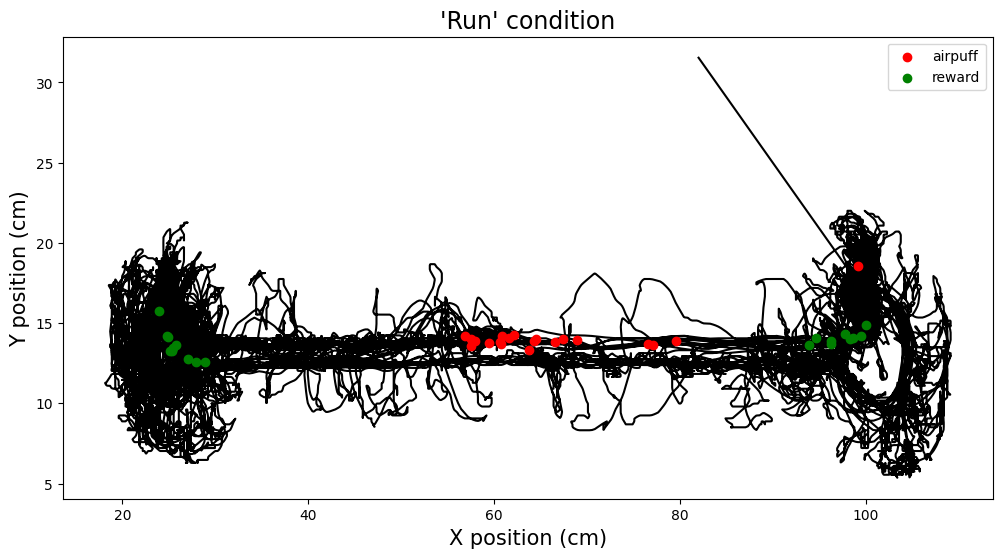

In [9]:
fig, ax = plt.subplots(figsize = (12,6))

# plotting position of the animal
ax.plot(pos_dict['x'][pos_dict['Condition']==3],
        pos_dict['y'][pos_dict['Condition']==3],
        color = 'k', zorder = 1)

# plotting positions of airpuffs
ax.scatter(pos_dict['x'][(pos_dict['Condition']==3) & (pos_dict['airpuff']==1)],
           pos_dict['y'][(pos_dict['Condition']==3) & (pos_dict['airpuff']==1)],
           color = 'red', label = 'airpuff', zorder = 2)

# plotting positions of rewards
ax.scatter(pos_dict['x'][(pos_dict['Condition']==3) & (pos_dict['reward']!=0)],
           pos_dict['y'][(pos_dict['Condition']==3) & (pos_dict['reward']!=0)],
           color = 'green', label = 'reward', zorder = 3)

# adding legends and labels
ax.set_title("'Run' condition", fontsize = 17)
ax.set_ylabel('Y position (cm)', fontsize = 15)
ax.set_xlabel('X position (cm)', fontsize = 15)
plt.legend()
plt.show()

### 2.2. Computing the average speed across positions

Hippocampal cells are selective to positions of the animal in the environment but they are also modulated by many other behavioral variables. In particular speed srtongly influences hippocamapal firing rates. Thus, if we want to understand the relationship between spatial coding and behavioral conditions, it is imperative that we have a clear picture of the relationship of latent variables such as speed with positions.

In this part, we want to compute the average speed across positions on the track. This method is important as we will basically use the same code to compute place field maps or any other analysis that involves averaging values in a variable as a function of another.

We will first compute this speed profile on the "run" condition, when the animal is going from the left to the right platform.

In [10]:
# Time indices for the run condition
tidx = (pos_dict['Condition'] == 3) & (pos_dict['laptype'] == 1 ) &  \
       (np.invert(np.isnan(pos_dict['Xpos']))) & (np.invert(np.isnan(pos_dict['Spd'])))

# Bin edges used to discretize Xpos
Xbinedges = np.arange(0, 101, 2)

# Number of bins
nXbins = len(Xbinedges) - 1

# Subsetting Xpos
Xpos = pos_dict['Xpos'][tidx]

# Discretizing and subsetting Xpos
Xpos_discrete = np.digitize(Xpos,Xbinedges)

# Subsetting Nav.Spd
Spd = pos_dict['Spd'][tidx]

# Summing speeds within indices of Xpos_discrete.
summap = sparse.csr_matrix( ( Spd, (np.zeros(Xpos_discrete.shape),Xpos_discrete-1) ),shape = (1,nXbins) ).toarray()

# Summing occurences for each bin of Xpos_discrete.
occmap = sparse.csr_matrix( ( np.ones(Spd.shape), (np.zeros(Xpos_discrete.shape),Xpos_discrete-1) ),shape = (1,nXbins) ).toarray()

# Smoothing summap and occmap with a Gaussian of s.d. of 1 bin
XsmthNbins = 1
npts= 5
x = np.arange(-(npts * XsmthNbins),(npts * XsmthNbins)+1)
Smoother = np.exp((-1*np.power(x,2) / (np.power(XsmthNbins,2)) /2))
summap = signal.convolve(summap.reshape(-1), Smoother, mode = 'same')
occmap = signal.convolve(occmap.reshape(-1), Smoother, mode = 'same')

# Calculating the average speed within each position bin by dividing summap with occmap.
spdmap = np.divide(summap, occmap)

The code above can be run by calling successively `Compute1DMap` and `GaussianSmooth1D`.

Have a look at these functions and use them to compute the speed profile across positions for the pre-ru, the run and the post-run conditions, sorting left and right trials.

In [11]:
Xbinsize = 2
Xbinedges = np.arange(0, 101, Xbinsize) # np.linspace(0,98,50)
nXbins = len(Xbinedges) -1 # len(Xbinedges)
XsmthNbins = 1

# Discretizing positions
Xpos_discrete = np.digitize(pos_dict['Xpos'], Xbinedges) # TODO
Xpos_discrete[Xpos_discrete>50] = 50

# Conditions to analyze
condList = [1,3,5]

# laptype to analyze
lapList = [-1,1]

# Iinitializing the final array
spdmap = np.empty((nXbins,len(lapList),len(condList))) * np.nan

for icond in range(len(condList)):
    for ilap in range(len(lapList)):
        # Time indices for the current condition and laptype
        tidx = (pos_dict['Condition'] == condList[icond]) & (pos_dict['laptype'] == lapList[ilap] ) &  \
               (np.invert(np.isnan(pos_dict['Xpos']))) & (np.invert(np.isnan(pos_dict['Spd'])))

        # Quick note:laptype is non-zero onlywhen the animal don't make
        # U-turns. However, in this case, it did a lot of u-turns on the run
        # condition. making the overall speed slower than in the other
        # condition actually

        # Computing the sum of speeds within indices of Xpos_discrete.
        summap = Compute1DMap( Xpos_discrete[tidx] , pos_dict['Spd'][tidx] , nXbins )

        # Smoothing the sum
        summap = GaussianSmooth1D(summap[0], XsmthNbins)

        # Computing the occupancy within each bin of Xpos_discrete.
        occmap = Compute1DMap(Xpos_discrete[tidx],np.ones(pos_dict['Spd'][tidx].shape),nXbins)

        # Smoothing the occupancy
        occmap = GaussianSmooth1D(occmap[0], XsmthNbins)

        # Calculating the average speed
        spdmap[:,ilap, icond] = np.divide(summap,occmap)

Compare the speed profiles across positions between conditions and type of
trials (L to R or R to L).

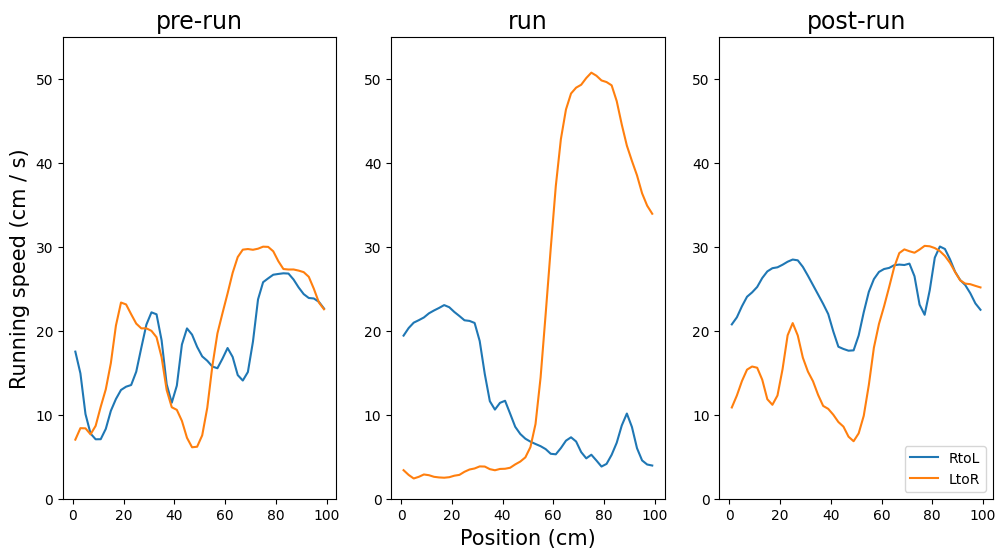

In [12]:
# Bin centers for plotting
Xbincenters = Xbinedges[:-1] + Xbinsize / 2

# Number of analyzed conditions
ncond = spdmap.shape[2]

# Maximium across all speeds for scaling purposes
m = 1.05 * np.max(spdmap)

# Condition labels for titling
condlabel = ['pre-run', 'run', 'post-run']

# Plotting conditions and type of trials in different subplots
fig, ax = plt.subplots(1,3, figsize = (12,6))

# plotting
for icond in range(ncond):
    ax[icond].plot(Xbincenters, spdmap[:,:,icond], label = ['RtoL','LtoR'])
    # title
    ax[icond].set_title(condlabel[icond], fontsize = 17)

# label and legend
ax[0].set_ylabel('Running speed (cm / s)', fontsize = 15)
ax[1].set_xlabel('Position (cm)', fontsize = 15)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles, labels, loc='lower right')

plt.setp(ax, ylim=(0, 55))
plt.show()

### 2.3. Computing air puff-triggered averages of speed

We want to understand a bit more how the air puffs influence the speed of the animal. One way to understand the connection between a continuous variable and a discrete set of events is by computing an event-trigerred average. This approach will allow us to determine whether a discernible pattern exists in the average speed of the rat (across all trials) in relation to the timing of airpuff application. It will also allow us to look in more details at what happed on a trial by trial basis.

Compute the air-puff triggered average of the animal's speed over a window of 2 seconds centered on the air puff events.

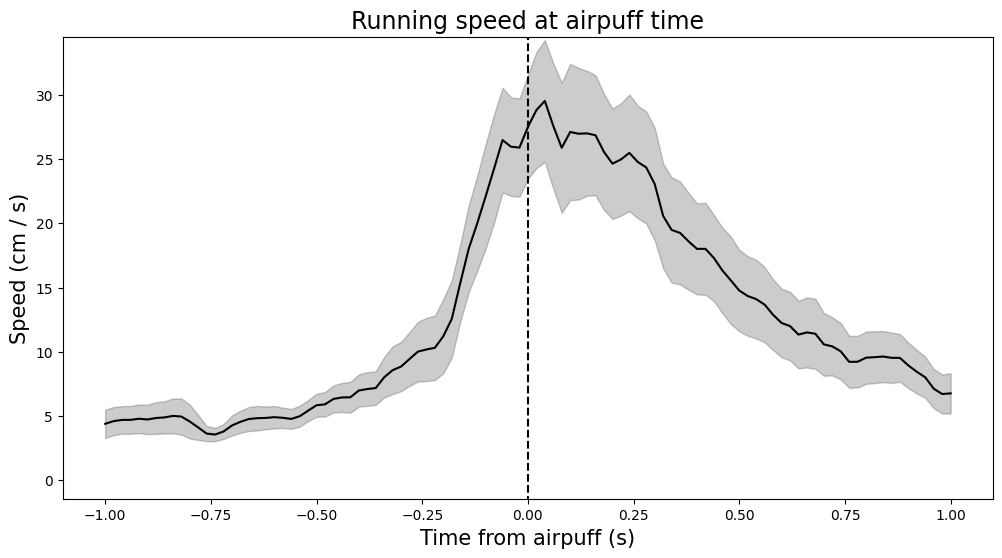

In [13]:
Spd = pos_dict['Spd']

# time indices where airpuffs are delivered
t = (np.argwhere(np.diff(pos_dict['airpuff'])==1)+1).reshape(-1)

# window of indices over which snippets will be extracted (-1 to 1 sec around air puff time)
idxwin = np.arange((-1 * params['sampleRate']),params['sampleRate']+1)

# Padding Spd
idxmax = max(abs(idxwin))
Spd = np.concatenate( (np.empty((idxmax))*np.nan, Spd, np.empty((idxmax))*np.nan) )

# Extracting snippets of Spd around timestamps in t
spdsnip = np.array([Spd[x + idxwin] for idx,x in enumerate(t + idxmax)])

# Average across snippets
spdAirpuff_ave = np.mean(spdsnip,0)

# S.E. across snippets
spdAirpuff_se = np.divide(np.std(spdsnip,axis=0, ddof=1) , np.sqrt(spdsnip.shape[0]))

# Plotting the result.
fig, ax = plt.subplots(figsize=(12,6))

# Plotting the line
ax.plot(idxwin/params['sampleRate'],spdAirpuff_ave,'k')
ax.vlines(0,min(spdAirpuff_ave)-10,max(spdAirpuff_ave)+10,'k','--')

# Plot shaded area between lower and upper bounds.
ax.fill_between(idxwin/params['sampleRate'],
                spdAirpuff_ave - spdAirpuff_se,
                spdAirpuff_ave + spdAirpuff_se,
                color ='k', alpha = .2)

# Labels, scalling and title
ax.set_ylim(min(spdAirpuff_ave)-5,max(spdAirpuff_ave)+5)
ax.set_xlabel('Time from airpuff (s)', fontsize = 15)
ax.set_ylabel('Speed (cm / s)', fontsize = 15)
ax.set_title('Running speed at airpuff time', fontsize = 17)

plt.show()

The event-triggered average procedure above can be done by calling `ComputeTriggeredAverage()`

Now, instead of looking at the average speed around air puffs in time, we would actually like to plot the average speed as a function of positions centered on the position where the air puff was delivered. This will allow us to see if things are consistent with the triggered average computed in the time domain.

Hint: one way to do that is by extracting the speed and positions snippets around air puff times before computing the spatial profile of speeds across positions from those snippets (after centering positions on the air puff position).

In [14]:
# First extract the snippet of speed around air puff times, just like above
Spd = pos_dict['Spd']

# time indices where airpuffs are delivered
t = (np.argwhere(np.diff(pos_dict['airpuff'])==1)+1).reshape(-1)

# Extracting snippets of Spd around timestamps in t
idxwin = np.arange((-1 * params['sampleRate']),params['sampleRate']+1)
_,_,spdsnip = ComputeTriggeredAverage(Spd, t, idxwin)

# Extracting snippets of Xpos around timestamps in t
Xpos = pos_dict['Xpos']
_,_,Xpossnip = ComputeTriggeredAverage(Xpos, t, idxwin)

# Centering positions on air puff position
puffpos = Xpossnip[:,idxwin == 0]
Xpossnip = Xpossnip - puffpos

# Extracting snippets of XDir around timestamps in t
XDir = pos_dict['XDir']
_,_,XDirsnip = ComputeTriggeredAverage(pos_dict['XDir'], t, idxwin)

# Removing positions and speeds which are not in the direction of travel when the airpuff occurs
airpuffdir = 1
Xpossnip[XDirsnip != airpuffdir] = np.nan
spdsnip[XDirsnip != airpuffdir] = np.nan

# Now we can compute the average speed as a function of positions, which are
# now aligned on the position of the air puffs.
# The dimension of the snippets don't really matter since we are interested
# in how one is related to the other. So let's reshape them as coloumn
# vectors for simplicity.
Xpossnip = Xpossnip.T.reshape(-1)
spdsnip = spdsnip.T.reshape(-1)

# Discretizing Xpossnip
binsize = 1
binedges = np.arange(-50,50+binsize,binsize)
nbins = len(binedges) - 1
smthNbins = 1

Xpos_discrete = np.digitize(Xpossnip, binedges) # TODO
Xpos_discrete = Xpos_discrete.astype(np.float32)
Xpos_discrete[np.isnan(Xpossnip)] = np.nan

# Computing the occupancy in each position bin
occmap = Compute1DMap(Xpos_discrete, np.ones(spdsnip.shape), nbins)

# Thresholding the occupancy before smoothin to make sure we don't get
# artifactual values where there were actually not enough data
occmap[occmap < 1] = np.nan
occmap = GaussianSmooth1D(occmap, smthNbins)

# Computing the sum of speeds in each position bin
summap = Compute1DMap(Xpos_discrete, spdsnip, nbins)

# Smoothing after removing values in positions with too few points
summap[np.isnan(occmap)] = np.nan
summap = GaussianSmooth1D(summap, smthNbins)

# Voila! Average speed across positions centered on air puffs
XspdAirpuff_run = np.divide(summap , occmap)

/content/Practicals-ratgroup/Tutorials python/functions.py:217: RuntimeWarning: invalid value encountered in divide
  output = np.divide(output,flat)


Let's quickly do the same for the pre-run and the post-run conditions so we can compare the speed profile across conditions.

There is no airr puffs in these conditions but to compare with the run condition, we'll use the mean position of air puffs to center positions.

In [15]:
# Mean position of air puffs in the run condition
meanpuffpos = np.nanmean(puffpos)

condList = [1,5]
idxwin = np.arange((-1 * params['sampleRate']),params['sampleRate']+1)
binsize = 1
binedges = np.arange(-50,50+binsize,binsize)
nbins = len(binedges) - 1
smthNbins = 1

for icond in range(len(condList)):
    # time indices where the animal is crossing the mean air puff position from left to right.
    t = np.argwhere( (np.diff( np.sign( pos_dict['Xpos'] - meanpuffpos) ) > 0) & (pos_dict['Condition'][:-1] == condList[icond]))

    # Extracting snippets of Spd around timestamps in t
    Spd = pos_dict['Spd']
    _,_,spdsnip = ComputeTriggeredAverage(Spd, t, idxwin)

    # Extracting snippets of Xpos around timestamps in t
    Xpos = pos_dict['Xpos']
    _,_,Xpossnip = ComputeTriggeredAverage(Xpos, t, idxwin)

    # Centering positions on mean air puff position.
    puffpos = Xpossnip[:,idxwin == 0]
    Xpossnip = Xpossnip - puffpos

    # Extracting snippets of XDir around timestamps in t
    XDir = pos_dict['XDir']
    _,_,XDirsnip = ComputeTriggeredAverage(XDir, t, idxwin)

    # Removing positions and speeds which are not in the direction of travel when the airpuff occurs
    airpuffdir = 1
    Xpossnip[XDirsnip != airpuffdir] = np.nan
    spdsnip[XDirsnip != airpuffdir] = np.nan

    Xpossnip = Xpossnip.T.reshape(-1)
    spdsnip = spdsnip.T.reshape(-1)

    # Discretizing Xpossnip
    Xpos_discrete = np.digitize(Xpossnip, binedges) # TODO
    Xpos_discrete = Xpos_discrete.astype(np.float32)
    Xpos_discrete[np.isnan(Xpossnip)] = np.nan

    # Computing the occupancy in each position bin
    occmap = Compute1DMap(Xpos_discrete, np.ones(spdsnip.shape), nbins)
    occmap[occmap < 1] = np.nan
    occmap = GaussianSmooth1D(occmap, smthNbins)

    summap = Compute1DMap(Xpos_discrete, spdsnip, nbins)
    summap[np.isnan(occmap)] = np.nan
    summap = GaussianSmooth1D(summap, smthNbins)

    if condList [icond] == 1:
        XspdAirpuff_pre = np.divide(summap , occmap)
    elif condList[icond] == 5:
        XspdAirpuff_post = np.divide(summap , occmap)

Plot the speed profiles triggered on air puff position for all three conditions

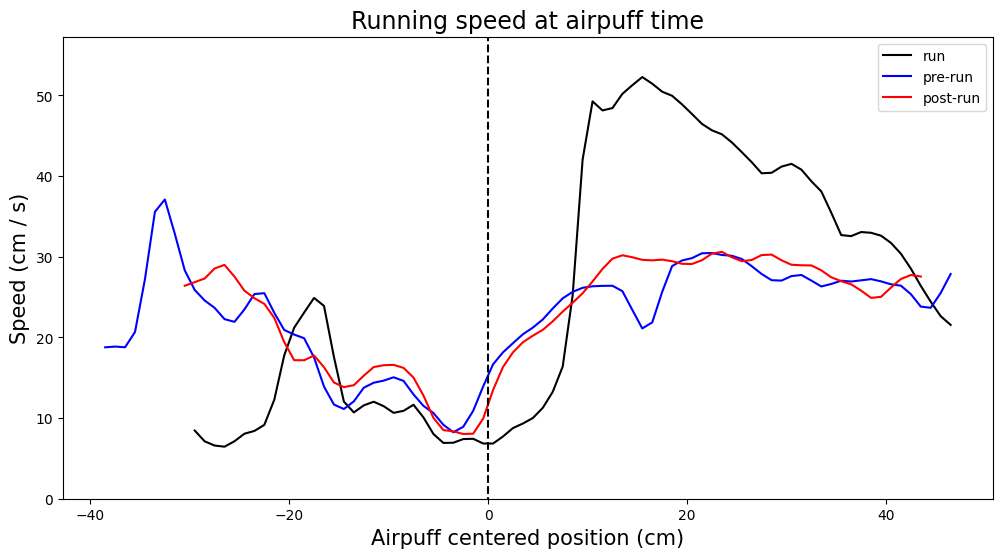

In [16]:
# bin centers for the X axes
bincenters = binedges[:-1] + binsize / 2

fig, ax = plt.subplots(figsize = (12,6))

# Plotting the speed profiles.
ax.plot(bincenters, XspdAirpuff_run.T, 'k',label = 'run')
ax.plot(bincenters, XspdAirpuff_pre.T, 'b',label = 'pre-run')
ax.plot(bincenters, XspdAirpuff_post.T, 'r',label = 'post-run')

# Plotting the middle line.
ax.vlines(0,np.nanmin(XspdAirpuff_run.T)-10,np.nanmax(XspdAirpuff_run)+10,'k','--')

# Labels, legend and title
ax.set_xlabel('Airpuff centered position (cm)', fontsize = 15)
ax.set_ylabel('Speed (cm / s)', fontsize = 15)
ax.set_title('Running speed at airpuff time', fontsize = 17)
ax.set_ylim(0,np.nanmax(XspdAirpuff_run)+5)
plt.legend(loc = 'upper right')
plt.show()

## 3.0 Matching spike times to behavioral data

Spikes are typically recorded with a higher sampling frequency than behavioral data. To correlate spikes with behavior we generate spiking samples (i.e. firing rate values) at the same sampling frequency as the behavioral data.

### 3.1. Load the spike times and the cluster info files.

In [17]:
# loading spike times and cluster ID in spk.HippoSpikes, a ntimes x 2 array
# containing spike times and clusters IDs in the firt and second columns respectively
spk = scipy.io.loadmat(mat_files['HippoSpikes'])

# loading information about clusters in spkinfo.IndexType, a ncells x 6
# array with the following information as columns: Rat, Session Number,
# shank number, neuron, neuronID and celltype (1 for Pyramidal, 2 for interneuron)
spkinfo = scipy.io.loadmat(mat_files['IndexType'])
spkinfo = spkinfo['IndexType']

### 3.2 Match spike sampling frequency with behavioral data.

All the spiking data will stored in a matlab structure (**Spk**), with different fields corresponding to different information about each cluster.

Copy the previously loaded spike times and cluster ID into the Spk structure by converting it to an array of spike trains, sampled at the same sampling rate as the behavioral data.

The timestamps of the behavioral data and the spike recording have already been aligned together.

In [18]:
# Removing spikes that are before or after behavior started
extraspk = (spk['HippoSpikes'][:,0] < pos_dict['sampleTimes'][0]) | (spk['HippoSpikes'][:,0] > pos_dict['sampleTimes'][-1])
spk['HippoSpikes'] = np.delete(spk['HippoSpikes'],extraspk,0)

# Saving spike times and cluster IDs into Spk dictionary
# We'll need it in the next days when correlating spikes with Lfp data that
# have a different sampling rate from the behavior.

spk_dict = {'spikeTimes':spk['HippoSpikes'][:,0],
            'spikeID':spk['HippoSpikes'][:,1]}

# convert spike times into an array of spike trains, at the same resolution
# as the behavioral data.

# list of clusters IDs
clustList = np.unique(spk['HippoSpikes'][:,1]).astype(int)

# number of clusters
ncells = max(clustList)

# number of time bins in the final spike train
nTimeSamples = len(pos_dict['sampleTimes'])

# Initializing Spk.spikeTrain
spk_dict['spikeTrain'] = np.zeros((nTimeSamples, ncells))

# Time bin edges to resample spike times
binEdges =  np.concatenate((pos_dict['sampleTimes'], np.array([max(pos_dict['sampleTimes']) + 1/params['sampleRate']])))

# Spike times resampled for each cell
for icell in clustList:
    s = spk['HippoSpikes'][spk['HippoSpikes'][:,1] == icell][:,0]
    spk_dict['spikeTrain'][:,icell-1] = np.histogram(s,binEdges)[0]

# Final timestamps of the spike trains
spk_dict['sampleTimes'] = pos_dict['sampleTimes']

### 3.3. Visualizing the activity of neurons as raster plots

Load the putative nature of the hippocampal clusters (i.e. pyramidal or interneuron)

In [19]:
# Indices of the clusters recorded in the hippocampus
HippoClustidx = np.isin(spkinfo[:,2],params['ShankList'])

# ShankID of each cluster
spk_dict['shankID'] = spkinfo[HippoClustidx,2]

# True if the cluster is a putative pyramidal cell
spk_dict['PyrCell'] = (spkinfo[HippoClustidx,5] == 1)*1

# True if the cluster is a putative interneuron
spk_dict['IntCell'] = (spkinfo[HippoClustidx,5] == 2)*1

Raster plot of all neurons together with the position of the animal over the first 100 seconds.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


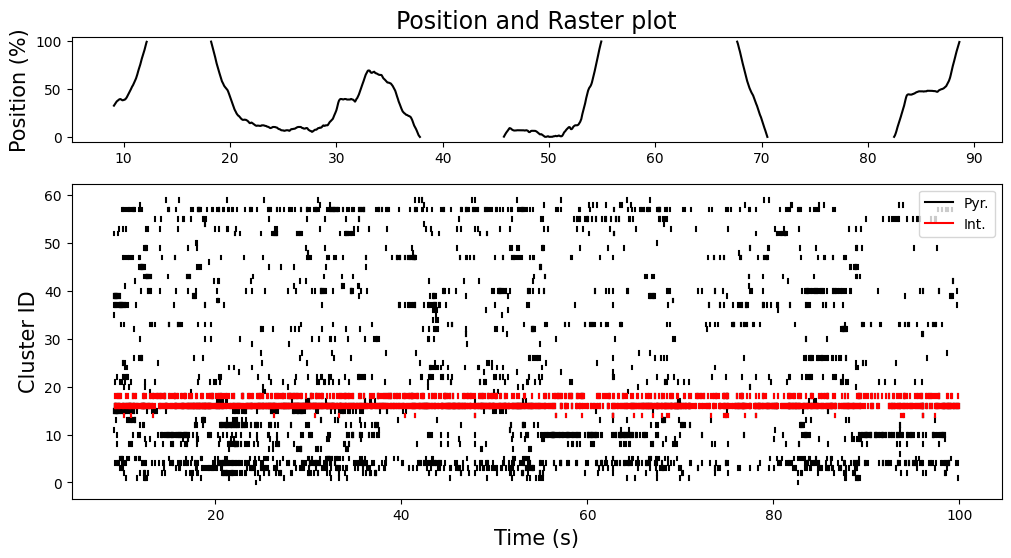

In [20]:
# time window over which to display the raster plot
timewin = [0,100]

# height of the ticks for each spike (between 0 and 1)
spkheight = 0.4

# Time indices corresponding to the requested time window
tidx = (spk_dict['sampleTimes'] >= timewin[0]) & (spk_dict['sampleTimes'] <= timewin[1])

# create the figure and the size ratios
fig, ax = plt.subplots(2,1,figsize = (12,6), gridspec_kw={'height_ratios': [1, 3]})

# Plotting the position of the animal on the track
ax[0].plot(spk_dict['sampleTimes'][tidx], pos_dict['Xpos'][tidx], 'k')

# finding the spike times and the cell IDs for each spikes
t = spk_dict['sampleTimes'][tidx]
idxs = np.argwhere(spk_dict['spikeTrain'][tidx,:] > 0)
xpoints = t[idxs[:,0]]
ypoints = idxs[:,1]
ax[1].plot([xpoints.T,xpoints.T],[(ypoints-spkheight).T,(ypoints+spkheight).T],'k');

# Overlaying spikes of interneurons in a different color
intspkidx = np.argwhere(spk_dict['IntCell'] == 1).reshape(-1)
ypointsInt = np.asarray([cellid if cellid in intspkidx else np.nan for cellid in ypoints])
ax[1].plot([xpoints,xpoints],[(ypointsInt-spkheight),(ypointsInt+spkheight)],'r');

# Scales, labels, legend etc...
ax[0].set_title('Position and Raster plot', fontsize = 17)
ax[0].set_ylabel('Position (%)', fontsize = 15)
ax[1].set_ylabel('Cluster ID', fontsize = 15)
ax[1].set_xlabel('Time (s)', fontsize = 15)

pyrcells = Line2D([0], [0],color='k', label='Pyr.')
intcells = Line2D([0], [0],color='r', label='Int.')
plt.legend(handles=[pyrcells, intcells])
plt.show()

## 4.0 Visualizing the spatial selectivity of hippocampal place cells

Hippocampal neurons known as place cells fire in specific locations. But some hippocampal place cells are also influenced by movement direction, especially within a 1-D linear track. Certain cells exhibit unidirectional firing, i.e. selective to a position but exclusively during Left-to-Right movements. In contrast, some cells show bidirectional firing behaviors, which may or may not be with the same place preference. We want to illustrate the place selectivity of hippocampal place cells in our data and their selectivity to movement direction within a 1-D linear track

### 4.1. Spatial selectivity and directionality of place cells

Plot the spikes of cells #1, #18 and #27 over the (X,Y) positions of the animal for conditions [1 3 5].

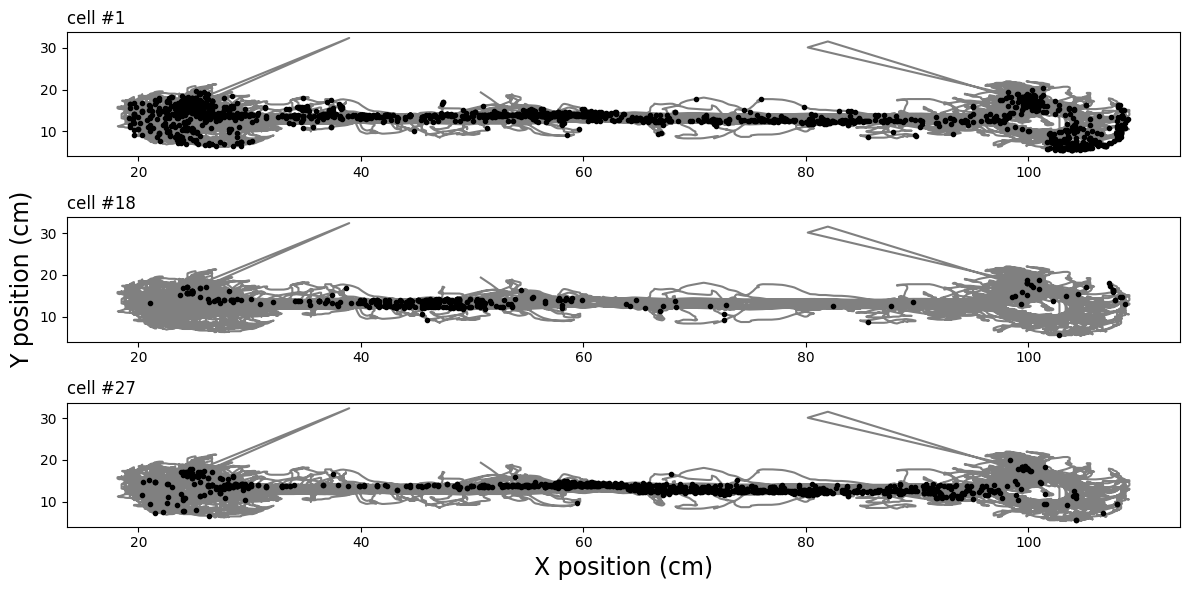

In [21]:
# Selecting time indices
tidx = np.isin(pos_dict['Condition'], [1,3,5])

# List of cells to plot - Attention! Python index starts with 0,
# so we should remove 1 to use the cells as indexes
cellList = np.asarray([1,18,27])

fig, ax = plt.subplots(3,1,figsize = (12,6))

for icell in range(len(cellList)):
    # plotting the trajectory of the animal
    ax[icell].plot(pos_dict['x'][tidx],pos_dict['y'][tidx], 'gray', zorder = 1)

    # plotting positions at spike times
    spkidx = spk_dict['spikeTrain'][:,cellList[icell]-1] > 0 # here we remove 1 because is an index
    ax[icell].plot(pos_dict['x'][(tidx) & (spkidx)], pos_dict['y'][(tidx) & (spkidx)],
                   '.', color = 'k', zorder = 2 )

    # labels, title, etc
    ax[icell].set_title('cell #{}'.format(cellList[icell]),loc='left')  # here we don't remove, just info
    if icell == 1:
        ax[icell].set_ylabel('Y position (cm)', fontsize = 17)
    elif icell == 2:
        ax[icell].set_xlabel('X position (cm)', fontsize = 17)

plt.tight_layout()
plt.show()

Compute the response profiles of cells #1, #18 and #27 across X positions (`pos_dict['Xpos']`) using `Compute1DMap()` and `GaussianSmooth1D()`. Do so seperately depending on the animal is moving in one direction or another (as estimated in `pos_dict['XDir']`).

In [22]:
# List of cells to plot
cellList = np.asarray([1,18,27])
ncells = len(cellList)

# Bins size, bin edges, and smoothing parameter for position
Xbinsize = 4
Xbinedges = np.arange(0,100+Xbinsize,Xbinsize)
nXbins = len(Xbinedges) - 1
XsmthNbins = 1

# Discretizing positions
Xpos = pos_dict['Xpos']
Xpos_discrete = np.digitize(Xpos, Xbinedges) # TODO
Xpos_discrete = Xpos_discrete.astype(np.float32)
Xpos_discrete[np.isnan(Xpos)] = np.nan
Xpos_discrete[Xpos_discrete>nXbins] = nXbins

# Condition to analyze
condList = [1,3,5]

# Direction to analyze
dirList = [-1,1]

# Iinitializing the final array
mapXDir = np.empty((ncells,nXbins, len(dirList)))*np.nan

for idir in range(len(dirList)):
    # Time indices for the current direction
    tidx = (np.isin(pos_dict['Condition'],condList)) & \
           (pos_dict['XDir'] == dirList[idir]) & \
           ~np.isnan(Xpos)

    # Computing the occupancy within each bin of Xpos_discrete.
    flat = np.ones(Xpos_discrete[tidx].shape) / params['sampleRate']
    occmap = Compute1DMap(Xpos_discrete[tidx], flat, nXbins)

    # Smoothing the occupancy
    occmap = GaussianSmooth1D(occmap, XsmthNbins)

    for icell in range(ncells):
        # Computing the spike count map within indices of Xpos_discrete.
        scmap = Compute1DMap(Xpos_discrete[tidx], spk_dict['spikeTrain'][tidx,cellList[icell]-1], nXbins)

        # Smoothing the spike count map
        scmap = GaussianSmooth1D(scmap, XsmthNbins)

        # Calculating the response spatial profile
        mapXDir[icell,:,idir] = np.divide(scmap,occmap)

Plot the response profiles along X for those three cells

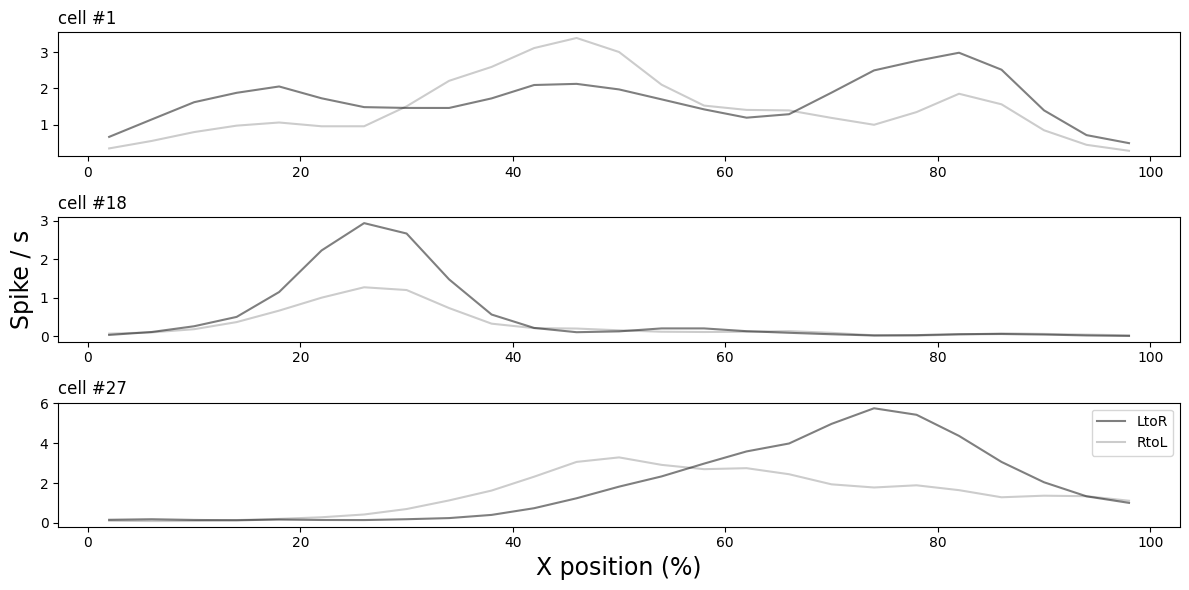

In [23]:
# IDs of cells in mapXDir
cellnum = np.asarray([1,18,27])

# Bin centers
Xbincenters = Xbinedges[:-1] + Xbinsize / 2

fig, ax = plt.subplots(3,1,figsize = (12,6))

for icell in range(mapXDir.shape[0]):
    # plotting the response profiles for both directions
    ax[icell].plot(Xbincenters,np.squeeze(mapXDir[icell,:,0]),
                   color = 'k', alpha = .5, label = 'LtoR')
    ax[icell].plot(Xbincenters,np.squeeze(mapXDir[icell,:,1]),
                   color = 'k', alpha = .2, label = 'RtoL')

    # labels, title, legend etc
    ax[icell].set_title('cell #{}'.format(cellList[icell]),loc='left')  # here we don't remove, just info
    if icell == 1:
        ax[icell].set_ylabel('Spike / s', fontsize = 17)
    elif icell == 2:
        ax[icell].set_xlabel('X position (%)', fontsize = 17)

plt.tight_layout()
plt.legend()

### 4.2. Spatial selectivity of place cells in 2D

Although recordings were performed on a linear track, we would sill like to visualize the response profiles of place cells along both X and Y.

Compute the 2D reponse profile across X and Y positions (`pos_dict['x']` and `pos_dict['y']`) for the same cells as above, using `Compute2DMap()` and `GaussianSmooth()`

In [24]:
# List of cells to plot
cellList = np.asarray([1,18,27])
ncells = len(cellList)

# Paramters for discretizing X
Xbinsize = 2
Xbinedges = np.arange(10,110+Xbinsize,Xbinsize)
nXbins = len(Xbinedges) - 1
XsmthNbins = 2

# Paramters for discretizing Y
Ybinsize = 0.5
Ybinedges = np.arange(5,25+Ybinsize,Ybinsize)
nYbins = len(Ybinedges) - 1
YsmthNbins = .5 # CHECK

# Discretizing X and Y positions
Xpos = pos_dict['x']
temp = np.digitize(Xpos, Xbinedges)
X_discrete = np.empty(temp.shape)*np.nan
for xdisc in range(len(temp)):
    if temp[xdisc] <= nXbins:
        X_discrete[xdisc] = temp[xdisc]

Ypos = pos_dict['y']
temp = np.digitize(Ypos, Ybinedges)
Y_discrete = np.empty(temp.shape)*np.nan
for ydisc in range(len(temp)):
    if temp[ydisc] <= nYbins:
        Y_discrete[ydisc] = temp[ydisc]

# Conditions to analyze
condList = [1,3,5]

# Iinitializing the final array
mapXY = np.empty((ncells, nYbins, nXbins)) * np.nan # TODO

# Time indices for the selected conditions
tidx =  np.isin(pos_dict['Condition'], condList)

# Computing the occupancy within each bin of X_discrete x Y_discrete.
flat = np.ones(X_discrete[tidx].shape) / params['sampleRate']
occmap = Compute2DMap(X_discrete[tidx], Y_discrete[tidx], flat, nXbins,nYbins)

# Excluding all values where occupancy is below a threshold
occmap[occmap < 0.2] = np.nan

# Smoothing the occupancy
occmap = GaussianSmooth2D(occmap, [YsmthNbins,XsmthNbins])

for icell in range(ncells):
    # Computing the spike count map within indices of Xpos_discrete.
    scmap = Compute2DMap(X_discrete[tidx], Y_discrete[tidx], spk_dict['spikeTrain'][tidx,cellList[icell]], nXbins, nYbins)

    # Excluding all values where occupancy is zero
    scmap[np.isnan(occmap)] = np.nan

    # Smoothing the spike count map
    scmap = GaussianSmooth2D(scmap, [YsmthNbins,XsmthNbins])

    # Calculating the response spatial profile
    mapXY[icell,:,:] = np.divide(scmap , occmap).T

/content/Practicals-ratgroup/Tutorials python/functions.py:273: RuntimeWarning: divide by zero encountered in divide
  output = output / flat
/content/Practicals-ratgroup/Tutorials python/functions.py:273: RuntimeWarning: invalid value encountered in divide
  output = output / flat


Plot the corresponding spatial profiles as colored maps

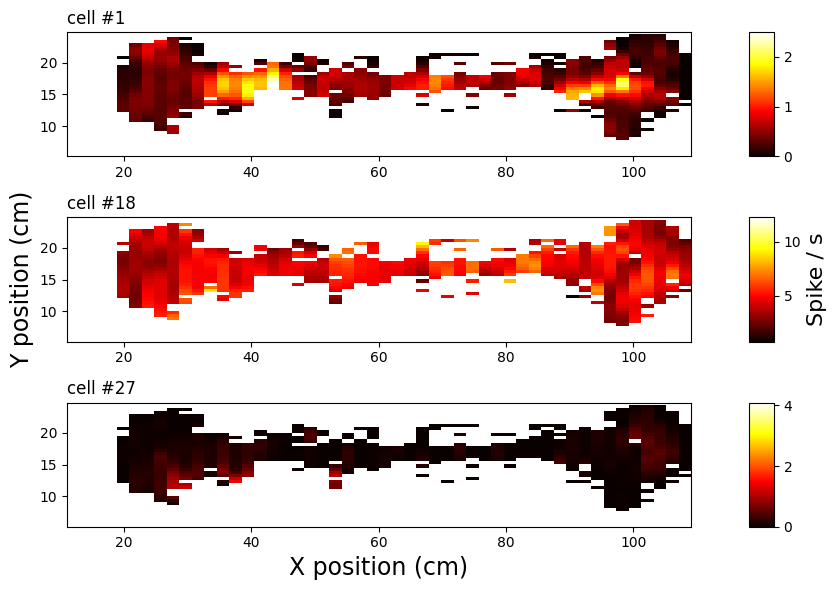

In [25]:
# Converting NaNs to inf so that it saturates when plotted
mapXY[np.isnan(mapXY)] = np.inf

# IDs of cells in mapXDir
cellnum = [1, 18, 27]

# Bin centers
Xbincenters = Xbinedges[:-1] + Xbinsize / 2
Ybincenters = Ybinedges[:-1] + Ybinsize / 2

# Create the figure
fig,ax = plt.subplots(3,1, figsize = (12,6))

for icell in range(mapXY.shape[0]):
    img = ax[icell].imshow(np.squeeze(mapXY[icell,:,:]), cmap = 'hot',
                           extent = [Xbincenters[0],Xbincenters[-1],Ybincenters[0],Ybincenters[-1]])

    # labels, title, legend etc
    ax[icell].set_title('cell #{}'.format(cellList[icell]),loc='left')  # here we don't remove, just info
    if icell == 0:
        cb = plt.colorbar(img, ax=ax[icell], aspect = 5)
    elif icell == 1:
        ax[icell].set_ylabel('Y position (cm)', fontsize = 17)
        cb = plt.colorbar(img, ax=ax[icell], aspect = 5)
        cb.set_label('Spike / s', fontsize=16)
    elif icell == 2:
        ax[icell].set_xlabel('X position (cm)', fontsize = 17)
        cb = plt.colorbar(img, ax=ax[icell], aspect = 5)


plt.tight_layout()
plt.show()